In [75]:
import numpy as np
import torch
import torch.nn.functional as F
from af22c.proteome import MultipleSeqAlign
import matplotlib.pyplot as plt
from timeit import timeit
from tqdm import tqdm
from itertools import combinations, chain
import time

In [2]:
prot_path = "../data/A0A0A0MRZ7.a3m"
prot = MultipleSeqAlign.from_a3m(prot_path)

100%|████████████████████████████████████| 9846/9846 [00:00<00:00, 82762.08it/s]


In [3]:
vocab = sorted(list(set("".join([str(prot.query_seq)] + [str(match.aligned_seq) for match in prot.matches]))))
"".join(vocab),len(vocab)

('-ACDEFGHIKLMNPQRSTVWXY', 22)

In [4]:
stoi = {c:i for i, c in enumerate(vocab)}
itos = {i:c for c, i in stoi.items()}

In [41]:
query_len = len(prot.query_seq)
num_matches = len(prot.matches)
num_seqs = num_matches + 1 # include query
query_len,num_matches,num_seqs

(120, 9844, 9845)

In [42]:
encmsa = torch.zeros((num_seqs, query_len))
for seqidx, seq in enumerate([prot.query_seq] + [match.aligned_seq for match in prot.matches]):
    for colidx, colval in enumerate(seq):
        encmsa[seqidx, colidx] = stoi[colval]
encmsa.shape

torch.Size([9845, 120])

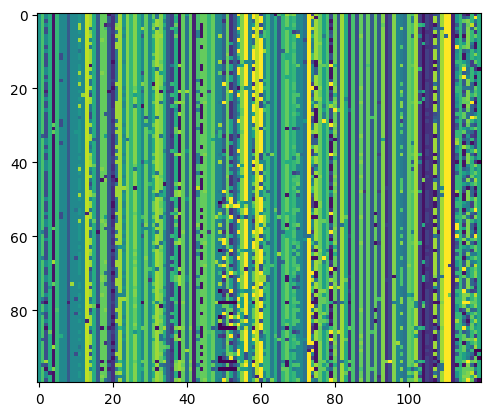

In [43]:
plt.imshow(encmsa[:100])

In [45]:
smallmsa = encmsa[:10,8:18] # (num_seqs, query_len)
# adjust variables for toy example
num_seqs, query_len = smallmsa.shape
num_matches = num_seqs - 1

Text(0.5, 0, 'AA index')

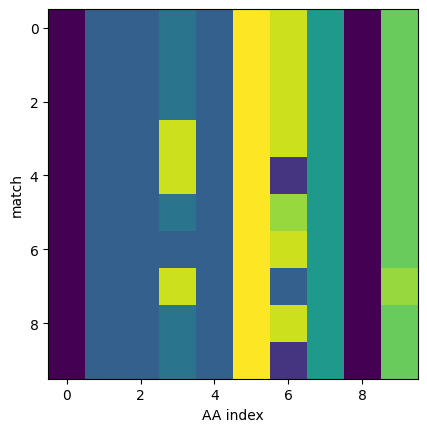

In [46]:
plt.imshow(smallmsa)
plt.ylabel("match")
plt.xlabel("AA index")

In [47]:
# pairwise hamming distances
pwdists = torch.sum(smallmsa[None,:,:] != smallmsa[:,None,:], axis=-1)
# pairwise sequence identities = 1 - normalized hamming distances (each value divided by sequence length)
pwseq = 1 - pwdists / query_len

Text(0, 0.5, 'query seq idx')

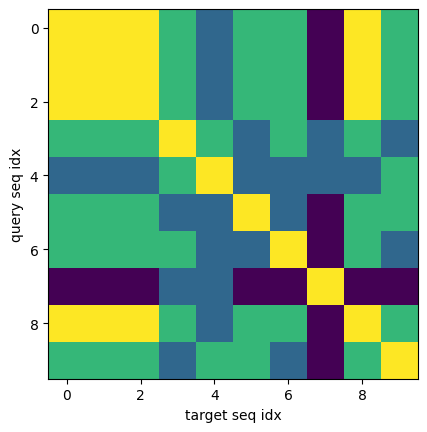

In [48]:
plt.imshow(pwseq)
plt.xlabel("target seq idx")
plt.ylabel("query seq idx")

In [13]:
pwseq[0,0],pwseq[0,3],pwseq[0,4],pwseq[0,7]

(tensor(1.), tensor(0.9000), tensor(0.8000), tensor(0.7000))

with our MSA sizes, it is probably not feasible to run sequence identity checks on the entire MSA. therefore, we need to divide the MSA into smaller batches.

In [15]:
batch_size = 4 # number of sequenes in batch
# calculate all pairs for which pairwise sequence identities need to be calculated
#pairs = torch.cartesian_prod(*(torch.arange(num_seqs),)*2)
pairs = []
for i in range(num_seqs):
    for j in range(i+1, num_seqs):
        pairs.append((i,j))
pairs = torch.tensor(pairs)
pairs.shape

torch.Size([45, 2])

In [16]:
# each batch should yield a matrix with batch_size elements
num_batches = (len(pairs) + batch_size - 1) // batch_size
num_batches

12

In [17]:
# one batch contains batch_size many pairs, which yields batch_size many similarity scores because the 
# similarity matrix is symmetric.
bpwseq = torch.eye(num_seqs) # matrix containing similarity scores for two sequences
for batch_idx in range(num_batches):
    # calculate similarity scores for a batch
    pairs_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
    batch_pairs = pairs[pairs_idx]

    # calculate sequences in batch
    batch_seqs = torch.zeros((batch_size, 2, query_len))
    for pair_idx, (i, j) in enumerate(batch_pairs):
        # TODO: get rid of float conversion?
        batch_seqs[pair_idx, 0] = smallmsa[i].float()
        batch_seqs[pair_idx, 1] = smallmsa[j].float()

    batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
    batch_pwseq = 1 - batch_pwdists / query_len
    for pair_idx, (i, j) in enumerate(batch_pairs):
        bpwseq[i,j] = bpwseq[j,i] = batch_pwseq[pair_idx]

Text(0.5, 1.0, 'complete MSA pairwise seq identity')

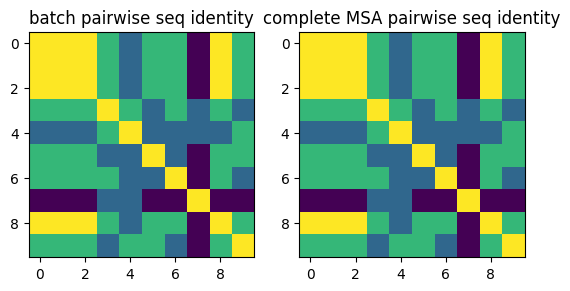

In [18]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.imshow(bpwseq)
ax1.set_title("batch pairwise seq identity")
ax2.imshow(pwseq)
ax2.set_title("complete MSA pairwise seq identity")

In [19]:
assert torch.allclose(bpwseq, pwseq)

In [28]:
# baseline: 30.474739761004457s
timeit(lambda: prot.compute_neff(), number=1)

16it [00:04,  3.21it/s]
100%|████████████████████████████████████████| 120/120 [00:00<00:00, 197.11it/s]


30.696222850005142

In [3]:
from neff_gpu import neff
neff

<function neff_gpu.neff(msa, pwseqfn=<function pwseq at 0x7f66488f1510>, seqid_thres=0.8, **kwargs)>

In [4]:
#timeit(lambda: compute_neff(prot), number=1)
# baseline: 20.309782647993416s
timeit(lambda: neff(prot, batch_size=10000), number=1)

converting msa: 9845it [00:04, 2254.48it/s]
running batches: 100%|████████████████████| 4846/4846 [00:02<00:00, 1844.94it/s]


20.120374978985637

## Combined functionality

The cells below combine the derived Neff score calculations from the cells above to be able to evaluate small changes to the function.

In [51]:
def fn1(encmsa):
    batch_size = 4 # number of sequenes in batch
    # calculate all pairs for which pairwise sequence identities need to be calculated
    #pairs = torch.cartesian_prod(*(torch.arange(num_seqs),)*2)
    pairs = []
    for i in range(num_seqs):
        for j in range(i+1, num_seqs):
            pairs.append((i,j))
    pairs = torch.tensor(pairs)
    
    # each batch should yield a matrix with batch_size elements
    num_batches = (len(pairs) + batch_size - 1) // batch_size
    
    bpwseq = torch.eye(num_seqs) # matrix containing similarity scores for two sequences
    for batch_idx in range(num_batches):
        # calculate similarity scores for a batch
        pairs_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
        batch_pairs = pairs[pairs_idx]

        # calculate sequences in batch
        batch_seqs = torch.zeros((batch_size, 2, query_len))
        for pair_idx, (i, j) in enumerate(batch_pairs):
            # TODO: get rid of float conversion?
            batch_seqs[pair_idx, 0] = encmsa[i].float()
            batch_seqs[pair_idx, 1] = encmsa[j].float()

        batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
        batch_pwseq = 1 - batch_pwdists / query_len
        for pair_idx, (i, j) in enumerate(batch_pairs):
            bpwseq[i,j] = bpwseq[j,i] = batch_pwseq[pair_idx]
    return bpwseq
assert torch.allclose(fn1(smallmsa), pwseq)

In [52]:
def fn2(encmsa):
    batch_size = 4 # number of sequenes in batch
    # calculate all pairs for which pairwise sequence identities need to be calculated
    #pairs = torch.cartesian_prod(*(torch.arange(num_seqs),)*2)
    pairs = []
    for i in range(num_seqs):
        for j in range(i+1, num_seqs):
            pairs.append((i,j))
    pairs = torch.tensor(pairs)
    
    # each batch should yield a matrix with batch_size elements
    num_batches = (len(pairs) + batch_size - 1) // batch_size
    
    bpwseq = torch.eye(num_seqs) # matrix containing similarity scores for two sequences
    for batch_idx in range(num_batches):
        # calculate similarity scores for a batch
        pairs_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
        batch_pairs = pairs[pairs_idx]
        batch_pairs_flat = batch_pairs.view(-1)
        
        # calculate sequences in batch
        batch_seqs = encmsa[batch_pairs_flat]
        batch_seqs = batch_seqs.view((-1, 2, query_len))

        # calculate pairwise distances 
        batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
        batch_pwseq = 1 - batch_pwdists / query_len
        
        # put at right location in result matrix
        bpwseq[batch_pairs[:,0],batch_pairs[:,1]] = batch_pwseq
        bpwseq[batch_pairs[:,1],batch_pairs[:,0]] = batch_pwseq
    return bpwseq
assert torch.allclose(fn2(smallmsa), pwseq)

In [53]:
print(f"fn1: {timeit(lambda: fn1(smallmsa), number=100)}s")
print(f"fn2: {timeit(lambda: fn2(smallmsa), number=100)}s")

fn1: 0.17003173200646415s
fn2: 0.0820879689999856s


## Move to GPU

In [13]:
def fn3(encmsa, device=None, batch_size = 4096, **kwargs):
    num_seqs,query_len = encmsa.shape

    # calculate all pairs for which pairwise sequence identities need to be calculated
    pairs = torch.triu_indices(*(num_seqs,)*2, 1, device=device).T
    
    # each batch should yield a matrix with batch_size elements
    num_batches = (len(pairs) + batch_size - 1) // batch_size
    
    bpwseq = torch.eye(num_seqs, device=device) # matrix containing similarity scores for two sequences
    for batch_idx in tqdm(range(num_batches), desc="running batches"):
        # calculate similarity scores for a batch
        pairs_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
        batch_pairs = pairs[pairs_idx]
        batch_pairs_flat = batch_pairs.view(-1)
        
        # calculate sequences in batch
        batch_seqs = encmsa[batch_pairs_flat]
        batch_seqs = batch_seqs.view((-1, 2, query_len))

        # calculate pairwise distances 
        batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
        batch_pwseq = 1 - batch_pwdists / query_len
        
        # put at right location in result matrix
        bpwseq[batch_pairs[:,0],batch_pairs[:,1]] = batch_pwseq
        bpwseq[batch_pairs[:,1],batch_pairs[:,0]] = batch_pwseq
    return bpwseq

In [14]:
def gapcount(encmsa, weights=None, gaptok=None, stoi=None, nongap=False, **kwargs):
    """
    calculate number of gaps in each msa column. returns a vector of length query_len.
    weights can be specified to weight each sequence in the msa column.
    if nongap=False (default), gaps will be counted; otherwise non-gaps will be counted.
    the gaps are identified by gaptok, which can be the token id for gaps. alternatively, a
    dictionary stoi can be supplied, where the gaptok is looked up.
    """
    if gaptok is None:
        assert stoi is not None
        gaptok = stoi['-']
    gapindicator = encmsa != gaptok if nongap else encmsa == gaptok
    if weights is not None:
        return weights @ gapindicator.float()
    return torch.sum(gapindicator, dim=0)

def neff(encmsa, pwseqfn=fn3, seqid_thres=0.8, **kwargs):
    """
    calculate neff scores for an encoded msa.
    """
    num_seqs, query_len = encmsa.shape
    pwseq = pwseqfn(encmsa, **kwargs)
    # calculate neff weights (dim can be 0 or 1, does not matter because pwseq is symmetric)
    neffweights = 1 / torch.sum(pwseq >= seqid_thres, dim=0)
    return gapcount(encmsa, weights=neffweights, nongap=True, **kwargs)

#neff_fast = neff(encmsa)

## Accellerating file loading

In the new neff score calculation, a lot of time is spent encoding the MSA. Can we combine file loading and encoding?

In [10]:
neffref = prot.compute_neff()

16it [00:05,  3.17it/s]
100%|████████████████████████████████████████| 120/120 [00:00<00:00, 198.70it/s]


In [11]:
from string import ascii_lowercase
def loadmsa(path):
    """load an MSA as an encoded tensor"""
    with open(path) as f:
        lines = f.readlines()
        assert not len(lines) & 1, f"MSA at {path} should contain an even number of lines"
        query_id = lines[0].split()[0]
        query_len = len([() for ch in lines[1].strip() if not ch in ascii_lowercase])
        
        # count header lines that are not just the query ID (1+ because first query is included in encoded msa)
        num_seqs = 1 + len([1 for line in lines[::2] if not line[:-1] == query_id and line.startswith(">")])
        
        # encode msa from lines
        encmsa = torch.zeros((num_seqs,query_len), dtype=torch.uint8)
        idx = 0
        for hdr, seq in zip(lines[::2], lines[1::2]):
            # skip query that appears multiple times in the file
            if idx > 1 and hdr[:-1] == query_id:
                continue
            # encode sequence
            encmsa[idx,:] = torch.tensor(
                # NB: stoi comes from outside!
                [stoi[ch] for ch in seq[:-1] if not ch in ascii_lowercase],
                dtype=torch.uint8,
            )
            idx += 1
        return encmsa

In [9]:
loadedmsa=loadmsa(prot_path)
loadedmsa.shape,len(prot.matches)+1

(torch.Size([9846, 120]), 9846)

In [15]:
# avg 5.556711397999607s per run
def f():
    loadedmsa=loadmsa(prot_path)
    return neff(loadedmsa, stoi=stoi)
timeit(f,number=4)

running batches: 100%|██████████████████| 11833/11833 [00:05<00:00, 2076.83it/s]


23.833697563997703

In [16]:
nefffast = f()

running batches: 100%|██████████████████| 11833/11833 [00:05<00:00, 2056.73it/s]


In [21]:
print(torch.tensor(neffref).float() - nefffast)
torch.allclose(torch.tensor(neffref).float(), nefffast) # yields true, are they "equal enough"? :3

tensor([-0.0006, -0.0005, -0.0005, -0.0002,  0.0012,  0.0022,  0.0073,  0.0076,
         0.0076,  0.0078,  0.0088,  0.0090,  0.0093,  0.0088,  0.0098,  0.0103,
         0.0120,  0.0125,  0.0132,  0.0112,  0.0024,  0.0054, -0.0132, -0.0415,
        -0.0415, -0.0420,  0.0088, -0.0435,  0.0034, -0.0410, -0.0430, -0.0430,
        -0.0444, -0.0444, -0.0444, -0.0439, -0.0444, -0.0439, -0.0449, -0.0449,
        -0.0454, -0.0444, -0.0454, -0.0386, -0.0186, -0.0425,  0.0034,  0.0093,
         0.0117,  0.0117,  0.0122,  0.0142,  0.0137,  0.0098, -0.0244, -0.0342,
        -0.0396, -0.0454, -0.0469, -0.0483, -0.0479, -0.0479, -0.0479, -0.0483,
        -0.0483, -0.0479, -0.0479, -0.0479, -0.0483, -0.0474, -0.0474, -0.0483,
        -0.0488, -0.0488, -0.0488, -0.0488, -0.0493, -0.0503, -0.0498, -0.0503,
        -0.0503, -0.0498, -0.0493, -0.0508, -0.0493, -0.0513, -0.0508, -0.0518,
        -0.0508, -0.0513, -0.0513, -0.0508, -0.0503, -0.0508, -0.0513, -0.0522,
        -0.0518, -0.0518, -0.0518, -0.05

True

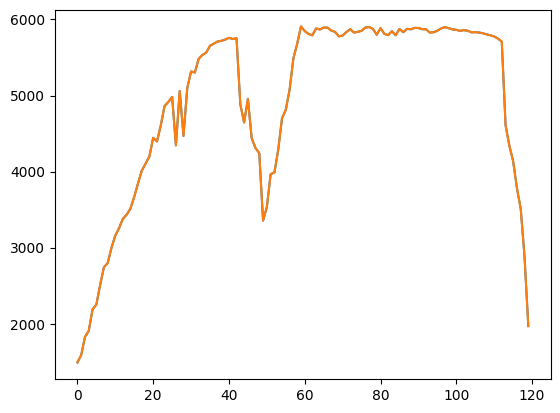

In [22]:
plt.plot(neffref)
plt.plot(nefffast)

In [94]:
# baseline: 15.939979004993802s
# with better pair generation: 4.461970445991028s
timeit(lambda: neff(loadmsa(prot_path), stoi=stoi), number=1)

generating pairs
done


running batches: 100%|███████████████████████████████████████████████████| 2959/2959 [00:04<00:00, 721.26it/s]


4.461970445991028

## Generating pairs

The second thing taking a long time is the generating a list of pairs that need to be processed. This can be done faster...

In [86]:
n,m=100,100
def combipairs(num_seqs):
    return list(combinations(range(num_seqs),2))
def triupairs(num_seqs):
    return torch.triu_indices(*(num_seqs,)*2,1).T

In [87]:
timeit(lambda: combipairs(n), number=1000)

0.12302115699276328

In [88]:
timeit(lambda: triupairs(n), number=1000)

0.006210542022017762

In [90]:
combipairs(4),triupairs(4)

([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)],
 tensor([[0, 1],
         [0, 2],
         [0, 3],
         [1, 2],
         [1, 3],
         [2, 3]]))

In [27]:
device = "cuda"
encmsa = loadmsa(prot_path).to(device)
neff(encmsa, device=device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.45 GiB (GPU 0; 5.92 GiB total capacity; 4.35 GiB already allocated; 261.81 MiB free; 4.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [55]:
batch_size = 5
num_seqs = 5

pairs = torch.triu_indices(*(num_seqs,)*2,1).T
num_full_batches = len(pairs) // batch_size
batch_pairs = pairs[:-(len(pairs)%batch_size)]
rest_pairs = pairs[-(len(pairs)%batch_size):]
pairs.shape,batch_pairs.shape,rest_pairs.shape

(torch.Size([10, 2]), torch.Size([0, 2]), torch.Size([10, 2]))

In [56]:
pairs,batch_pairs,rest_pairs

(tensor([[0, 1],
         [0, 2],
         [0, 3],
         [0, 4],
         [1, 2],
         [1, 3],
         [1, 4],
         [2, 3],
         [2, 4],
         [3, 4]]),
 tensor([], size=(0, 2), dtype=torch.int64),
 tensor([[0, 1],
         [0, 2],
         [0, 3],
         [0, 4],
         [1, 2],
         [1, 3],
         [1, 4],
         [2, 3],
         [2, 4],
         [3, 4]]))

In [57]:
ptr = lambda t: t.storage().data_ptr()
ptr(pairs),ptr(batch_pairs),ptr(rest_pairs)

(93849648980608, 93849648980608, 93849648980608)

In [58]:
ptr(batch_pairs.view(num_full_batches, -1, 2))

93849648980608

In [61]:
for bp in chain(batch_pairs.view(num_full_batches, -1, 2), [rest_pairs]):
    print(ptr(bp.view(-1)))

93849648980608
93849648980608


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

compare the performance of two versions of the pwseq function.

In [63]:
# baseline
def pwseq1(encmsa, device=None, batch_size=2**18, **kwargs):
  """return pairwise sequence identity calculated with pytorch"""
  num_seqs,query_len = encmsa.shape
  
  # calculate all pairs for which pairwise sequence identities need to be calculated
  pairs = torch.triu_indices(*(num_seqs,)*2, 1, device=device).T
  
  # each batch should yield a matrix with batch_size elements
  num_batches = (len(pairs) + batch_size - 1) // batch_size
  
  # one batch contains batch_size many pairs, which yields batch_size many similarity scores because the 
  # similarity matrix is symmetric.
  bpwseq = torch.eye(num_seqs, device=device) # matrix containing similarity scores for two sequences
  for batch_idx in tqdm(range(num_batches), desc="running batches"):
    # calculate similarity scores for a batch
    pairs_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
    batch_pairs = pairs[pairs_idx]
    batch_pairs_flat = batch_pairs.view(-1)
    
    # calculate sequences in batch
    batch_seqs = encmsa[batch_pairs_flat]
    batch_seqs = batch_seqs.view(-1, 2, query_len)

    # calculate pairwise distances 
    batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
    batch_pwseq = 1 - batch_pwdists / query_len
    
    # put at right location in result matrix (and make symmetric)
    bpwseq[batch_pairs[:,0],batch_pairs[:,1]] = batch_pwseq
    bpwseq[batch_pairs[:,1],batch_pairs[:,0]] = batch_pwseq
  return bpwseq

In [91]:
def pwseq2(encmsa, device=None, batch_size=2**16, **kwargs):
  """return pairwise sequence identity calculated with pytorch"""
  num_seqs,query_len = encmsa.shape
  
  # calculate all pairs for which pairwise sequence identities need to be calculated
  pairs = torch.triu_indices(*(num_seqs,)*2, 1, device=device).T
  
  # each batch should yield a matrix with batch_size elements
  num_batches = (len(pairs) + batch_size - 1) // batch_size
  num_full_batches = len(pairs) // batch_size
  
  batch_pairs = pairs[:-(len(pairs)%batch_size)]
  rest_pairs = pairs[-(len(pairs)%batch_size):]

  #checkpoints = "seq_extract pwdists putback"
  #t = {name: 0 for name in checkpoints.split()}
  
  # put pairs into batches
  batches = batch_pairs.view(num_full_batches, -1, 2)
  if num_batches != num_full_batches:
    batches = chain(batches, [rest_pairs])
    
  # one batch contains batch_size many pairs, which yields batch_size many similarity scores because the 
  # similarity matrix is symmetric.
  bpwseq = torch.eye(num_seqs, device=device) # matrix containing similarity scores for two sequences
  for batch_pairs in tqdm(batches, total=num_batches, desc="running batches"):
    # view batch_pairs as a flat array
    #start = time.perf_counter()
    #print(f"{batch_pairs.shape=}")
    #batch_pairs_flat = batch_pairs.view(-1)
    #break
    #end = time.perf_counter()
    #t["pairflatten"] += end - start
    
    # extract sequences in batch
    #start = time.perf_counter()
    #batch_seqs = encmsa[batch_pairs_flat]
    batch_seqs = encmsa[batch_pairs]
    #batch_seqs = batch_seqs.view(-1, 2, query_len)
    #print(f"{batch_seqs.shape}")
    #end = time.perf_counter()
    #t["seq_extract"] += end - start

    # calculate pairwise distances 
    #start = time.perf_counter()
    batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
    batch_pwseq = 1 - batch_pwdists / query_len
    #end = time.perf_counter()
    #t["pwdists"] += end - start
    
    # put at right location in result matrix (and make symmetric)
    #start = time.perf_counter()
    bpwseq[batch_pairs[:,0],batch_pairs[:,1]] = batch_pwseq
    bpwseq[batch_pairs[:,1],batch_pairs[:,0]] = batch_pwseq
    #end = time.perf_counter()
    #t["putback"] += end - start
  
  c = sum(t.values())
  #for name, total in t.items():
  #  print(f"{name}: {total}s={100*total/c:.01f}%, {total/num_batches}s/batch")
  #print(f"sum={c}")
  
  return bpwseq

In [96]:
pwseq2(encmsa, batch_size=batch_size)

pairs.shape=torch.Size([48466935, 2])


running batches: 100%|██████████████████████████████████████████| 11833/11833 [00:05<00:00, 2175.40it/s]


tensor([[1.0000, 0.8417, 0.7917,  ..., 0.1250, 0.2250, 0.1083],
        [0.8417, 1.0000, 0.9000,  ..., 0.1167, 0.2333, 0.1250],
        [0.7917, 0.9000, 1.0000,  ..., 0.1167, 0.2333, 0.1167],
        ...,
        [0.1250, 0.1167, 0.1167,  ..., 1.0000, 0.6333, 0.6667],
        [0.2250, 0.2333, 0.2333,  ..., 0.6333, 1.0000, 0.6500],
        [0.1083, 0.1250, 0.1167,  ..., 0.6667, 0.6500, 1.0000]])

In [85]:
encmsa = loadmsa("../data/A0A0A0MRZ7.a3m")
encmsa.shape

torch.Size([9846, 120])

In [86]:
batch_size=2**12

In [93]:
print("baseline", timeit(lambda: pwseq1(encmsa, batch_size=batch_size), number=3))

running batches: 100%|██████████████████████████████████████████| 11833/11833 [00:05<00:00, 2338.65it/s]

baseline 15.88429386500502


In [95]:
print("version 2", timeit(lambda: pwseq2(encmsa, batch_size=batch_size), number=3))

pairs.shape=torch.Size([48466935, 2])


running batches: 100%|██████████████████████████████████████████| 11833/11833 [00:04<00:00, 2562.39it/s]


pairs.shape=torch.Size([48466935, 2])


running batches: 100%|██████████████████████████████████████████| 11833/11833 [00:05<00:00, 2227.25it/s]


pairs.shape=torch.Size([48466935, 2])


running batches: 100%|██████████████████████████████████████████| 11833/11833 [00:05<00:00, 2249.20it/s]

version 2 15.537462737003807
